# 🐕 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data this notebook uses is from Kaggle's dog breed identification competition:
https://www.kaggle.com/c/dog-breed-identification/overview

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set. (These images have labels)
* There are around 10,000+ images in the test set. (These images have no labels, because we will want to predict them).


### Get the workspace tools

* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure a GPU is being used. ✅

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# Import TensorFlow and TensorFlow Hub 
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availablity
print("GPU", "available (Yes!)" if tf.config.list_physical_devices('GPU') else "not avalable :(")


2025-02-09 11:38:43.971345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739068725.330311   17339 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739068725.712288   17339 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 11:38:49.327118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF version: 2.18.0
TF Hub version: 0.16.1
GPU available (Yes!)


In [2]:
# This will limit the amount of GPU memory that is allocated to tensorflow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 6GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1739068788.591042   17339 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:2b:00.0, compute capability: 7.5


In [3]:
# Import these for interactive features on Jupyter notebooks
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations)

Let's start by accessing our data and checking out the labels.

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("data/labels.csv")

print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: xlabel='breed'>

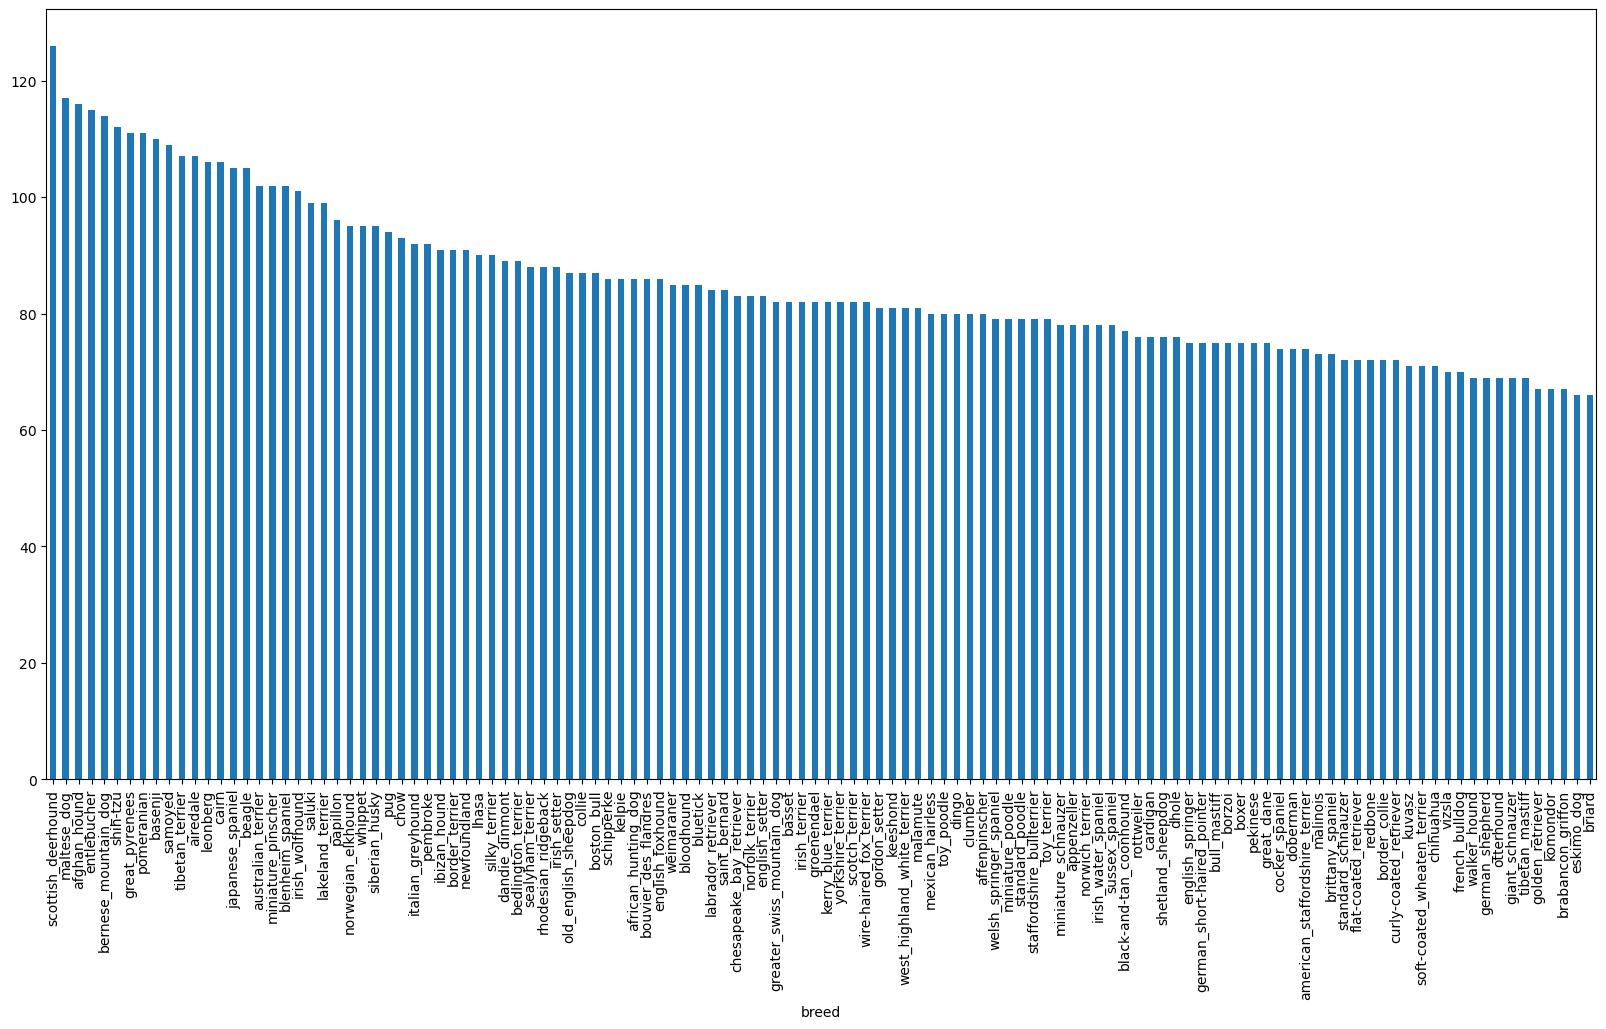

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [6]:
labels_csv["breed"].value_counts().median()

82.0

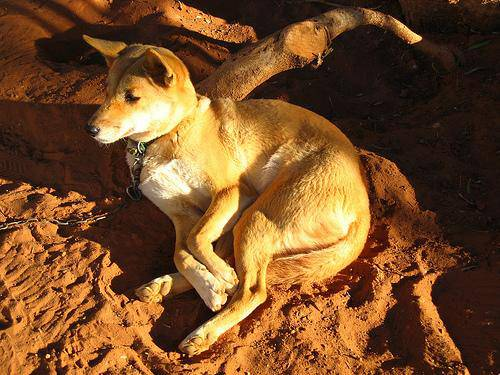

In [7]:
# Let's view an image
from IPython.display import Image
Image("data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.


In [8]:
# Create pathnames from image ID's

filenames = ["data/train/"+ fname for fname in labels_csv["id"]+ ".jpg"]

# Check the first 10

filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
# Check whether number of filenames matches the number of actual image files
import os
if len(os.listdir("data/train/")) == len(filenames):
  print("Filenames match actual amount of files Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files Proceed.


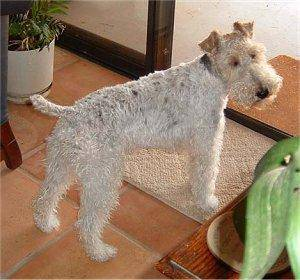

In [10]:
# One more check
Image(filenames[7000])

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [11]:
import numpy as np

labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does the same thing as .to_numpy
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
len(labels)

10222

In [13]:
# See if the number of labels matches the filenames
if len(labels) == len(filenames):
  print("The number of labels matches the number of filenames!")
else:
  print("Number of labels does not match the number of filenames, check data directories!")

The number of labels matches the number of filenames!


In [14]:
# Find the unique label values
unique_breeds = (np.unique(labels))

unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [15]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into boolean array

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels)

10222

In [18]:
# Example Turning boolean array in integers
print(labels[0]) # original label
print(np.where(unique_breeds) == labels[0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
False
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation data set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [19]:
# Set up X & y variables

X = filenames
y = boolean_labels

I will start start off experimenting with ~1000 images and increase as needed.

In [20]:
# When experimenting: start with a smaller sample to reduce wait time between experiments
#@param {type:"slider", min:1000, max:10000, step:1000} # use this to create a slider in Google Colab
NUM_IMAGES = widgets.IntSlider(min=1000, max=10000, step=1000, value=1000);
display(NUM_IMAGES)


IntSlider(value=1000, max=10000, min=1000, step=1000)

In [21]:
# Let's Split our data in to train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES.value],
                                                  y[:NUM_IMAGES.value],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [22]:
# Let's have look at the draining data
X_train[:5], y_train[:5]

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [23]:
# Convert an image to a NumPy array
from matplotlib.pyplot import imread

image = imread(filenames[42])
image.shape

(257, 350, 3)

In [24]:
# the NumPy image array into a Tensor

tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen awhat an image lookslike as a Tensor, let's make a function to preprocess them.

In [25]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if needed)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [26]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the related label, processes the image and returns a tuple 0f (image, label).
  """
  image = process_image(image_path)
  return image, label

In [27]:
get_image_label(X[42], y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form:
`(image_path, label)`, let make a function to turn all of our data into batches!

In [28]:
# Define the batch size, 32 is a good start

BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles tthe data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels (y)).
  """
  # If the data is a test dataset, we probably don't have labels (y)
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths and labels
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shiffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch

In [29]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training batches...
Creating validation data batches...


In [30]:
# Check out the different attributes of our data batches

train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

OUr data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [31]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Display a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")


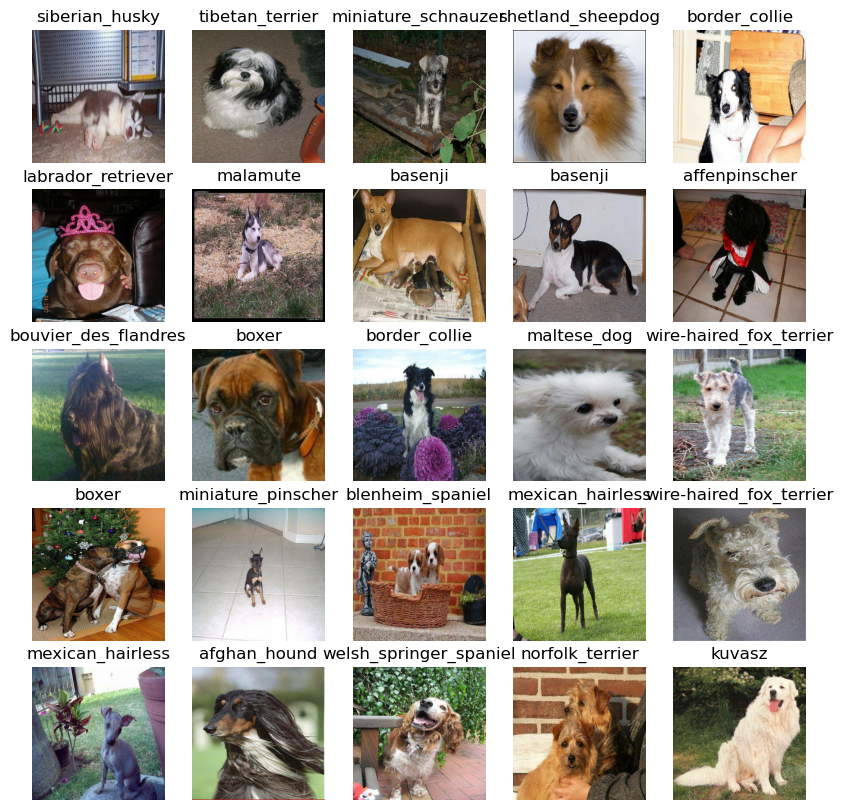

In [32]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

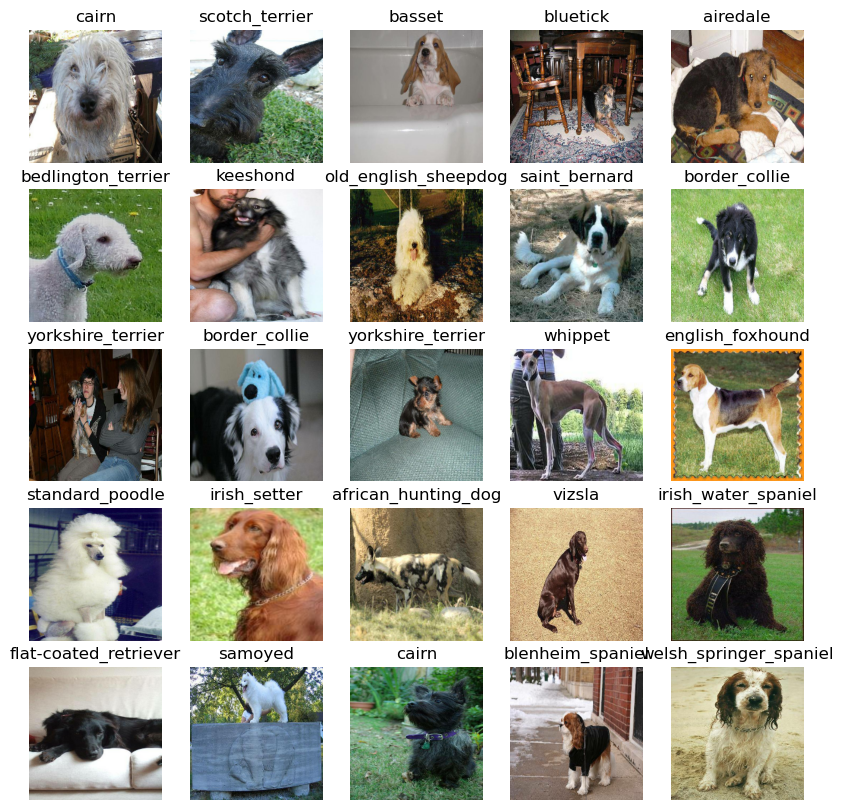

In [33]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:

* Tfhe `input` shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from Kaggle (TensorFlow Hub).

In [34]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# setup the output shape
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub

MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2"


Now we've got our inputs, outputs, and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this m then that).
* Compiles the model (says how it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting).
* Returns the `model`.


In [35]:
# Use Keras 2 (This helps to avoid errors between Tensorflow Hub and keras Sequential versions)
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

In [36]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup model layers
  # Wrap the KerasLayer in a Lambda layer to ensure it's recognized as a Keras Layer (do this when using Google Colab)
  model = keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])
  # Compile the model
  model.compile(
      loss=keras.losses.CategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [37]:
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


### Creating callbacks

Callbacks are a helper functions a model can use during training to do such things as save its progress, check it progress or stop training early if a model stops improving.

We'll create two two callbacks, one for TensorBoard which helps track our models progress and another for early stopping, which prevent our model from training for too long.

### TensorBoard callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function ✅
3. Visualize our model's training logs with the `%tensorboard` magic function (we'll do this after the model training)

In [38]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [39]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("logs",
                          # Make it so the logs get tracked whenever we run an experiment
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

early stopping helps our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [40]:
# Create early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)


## Training a model (on a subset of data)

Our first model is only going to train on 1000 images to make sure everything is working.

In [41]:
# Define the number of epochs (The number of chances to learn patterns)
NUM_EPOCS = widgets.IntSlider(min=10, max=100, step=10, value=100);
display(NUM_EPOCS)
print(f"The current number of epochs: {NUM_EPOCS.value}")

IntSlider(value=100, min=10, step=10)

The current number of epochs: 100


In [42]:
# Check to make sure we are running on a GPU

print("GPU", "available (YESSS!!!)" if tf.config.list_physical_devices('GPU') else "not available :(")

GPU available (YESSS!!!)


Let's create a function which trains a model

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train (`NUM_EPOCS`) and the callbacks we'd like to use.
* Return the model

In [43]:
# Build a function to train and return a model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()

    # Create new TensorBoard session every time we create a model.
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created.
    model.fit(x=train_data,
              epochs=NUM_EPOCS.value,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping])
    # Return the fitted model
    return model

In [44]:
# Fit the model to the data 
model = train_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Epoch 1/100


I0000 00:00:1739069128.020637   17603 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1739069133.517579   17605 service.cc:148] XLA service 0x7f0f8d152e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739069133.518164   17605 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-02-09 11:45:33.729759: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739069132.694253   17605 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 14s 111ms/step - loss: 4.6791 - accuracy: 0.0950 - val_loss: 3.5628 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 2s 60ms/step - loss: 1.7170 - accuracy: 0.6775 - val_loss: 2.2409 - val_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 1s 58ms/step - loss: 0.5978 - accuracy: 0.9287 - val_loss: 1.7569 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 1s 58ms/step - loss: 0.2578 - accuracy: 0.9862 - val_loss: 1.5346 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 2s 60ms/step - loss: 0.1502 - accuracy: 0.9975 - val_loss: 1.4577 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 1s 58ms/step - loss: 0.1025 - accuracy: 1.0000 - val_loss: 1.4072 - val_accuracy: 0.6600
Epoch 7/100
25/25 [==============================] - 2s 60ms/step - loss: 0.0764 - accuracy: 1.0000 - val_loss: 1.3760 - val_accuracy: 0.6600
Epoch 8/100
25/2

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It mean our model is learning!!!

### Checking the TensorBoard Logs

The Tensorboard magic function (`%tensorboard`) will access the log directory we created earlier and visualize it contents

In [56]:
%tensorboard --logdir logs --host localhost

## Making and evaluating predictions using a trainded model

In [57]:
# Make predictions on the validation data batch

predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 103ms/step


array([[2.0472105e-03, 5.0290437e-05, 1.3661887e-03, ..., 4.0226156e-04,
        7.7212080e-06, 9.7756181e-04],
       [1.1077109e-03, 3.0124318e-04, 3.1828606e-03, ..., 3.1039142e-04,
        3.6028671e-04, 4.7851121e-05],
       [4.8736833e-06, 2.8574574e-05, 4.5436782e-06, ..., 6.9019654e-05,
        2.5744834e-05, 4.8677779e-05],
       ...,
       [1.8191349e-05, 1.3847191e-04, 1.5041594e-04, ..., 8.0133905e-05,
        2.4961910e-04, 3.7206477e-04],
       [1.7582077e-03, 1.3072438e-04, 5.8519567e-05, ..., 2.5803491e-04,
        2.7347724e-05, 1.4877999e-02],
       [8.1078650e-04, 5.5615914e-05, 9.3771927e-03, ..., 3.3304757e-03,
        1.4157268e-03, 2.9013914e-05]], dtype=float32)

In [58]:
# breakdown of what the predict function does  
index = 42
predictions[index] # gives a probability array. The higest number is the predicted label for this location.
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # gives the max value within the array at a given index
print(f"Number of predictions: {len(predictions[index])}") # the number of possible predictions (the number of labels)
print(f"Sum: {np.sum(predictions[index])}") # the sum should be 1 or close to 1
print(f"Matrix shape of all predictions: {predictions.shape}") # Gives the shape (200, 120) y_val(real_values) = 200 , 120 = unique_breeds (labels)
print(f"Index location of max value: {np.argmax(predictions[index])}")  # locates the index with the max value for a prediction array location. (predictions[index][maxvalue])
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

Max value (probability of prediction): 0.2795984447002411
Number of predictions: 120
Sum: 1.0
Matrix shape of all predictions: (200, 120)
Index location of max value: 113
Predicted label: walker_hound


## Having the above functionality is good but we want to be able to do this at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [59]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turn an array of prediction probabilities into a label
    """
    return unique_breeds[np.argmax(prediction_probabilities)]
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[15])
pred_label

'miniature_poodle'

In [60]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Now since our validation data is still in a batch dataset, we'll have to unbatch it to make predictions on the validation labels(truth labels)

In [61]:
# Create a function to unbatch a batch dataset.
def unbatch_dataset(batched_dataset):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels
    """
    images = []
    labels = []
    # Loop through unbatch data
    try:
        
        for image, label in batched_dataset.unbatch().as_numpy_iterator():
            images.append(image)
            labels.append(unique_breeds[np.argmax(label)])
    except tf.errors.OutOfRangeError:
        # Handle out of range error
        print("Index out of range")
    # Return the unbatched data
    return images, labels


In [62]:
# Unbatch the validation data
val_images, val_labels = unbatch_dataset(val_data)

2025-02-09 12:04:34.122615: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [63]:
get_pred_label(val_labels[42])

'affenpinscher'

Now we've got way to get:
* prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all more visual.

We'll create a function which:
* Take of an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prdiction probabilities. to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [64]:
# create a function to visualiza a prediction
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    #Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"
        
    # Change plot title to be predicted, probability of prediction and truth
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)
    


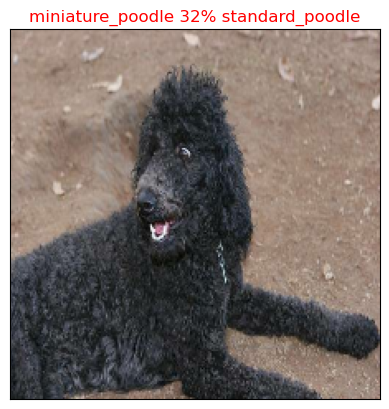

In [66]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=47)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of input prediction probabilities array and a ground truth array and an integer ✅
* Find the predicted label using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probabilities and labels, coloring the true label green ✅

In [67]:
# create a funtion plot prediction confidence intervals top 10 predictions 
def plot_pred_conf(prediction_probabilites, labels, n=1):
    """
    Plot the 10 highest prediction confidences along with the true label for sample n.
    """
    pred_prob, true_label = prediction_probabilites[n], labels[n]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")

    # Change the color of the 
    if np.isin(true_label, top_10_pred_labels ):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass        

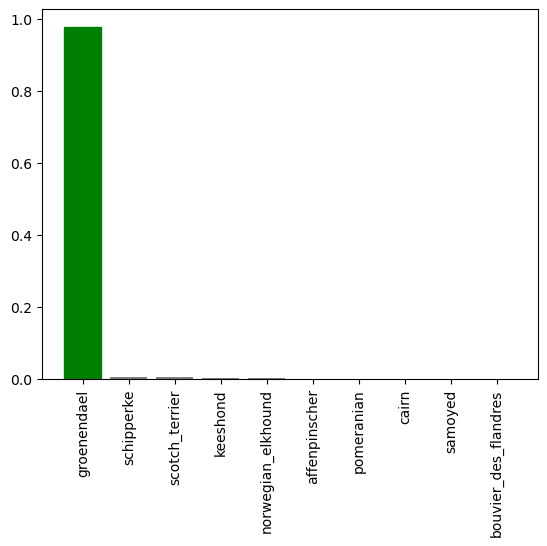

In [70]:
plot_pred_conf(prediction_probabilites=predictions,
               labels=val_labels,
               n=77)

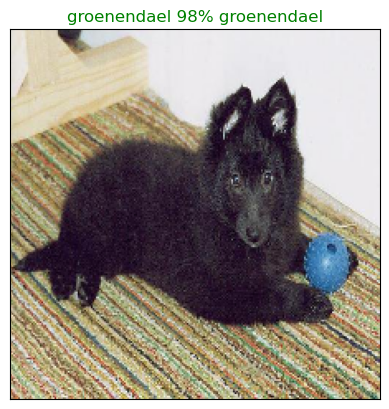

In [71]:
# check 
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few .

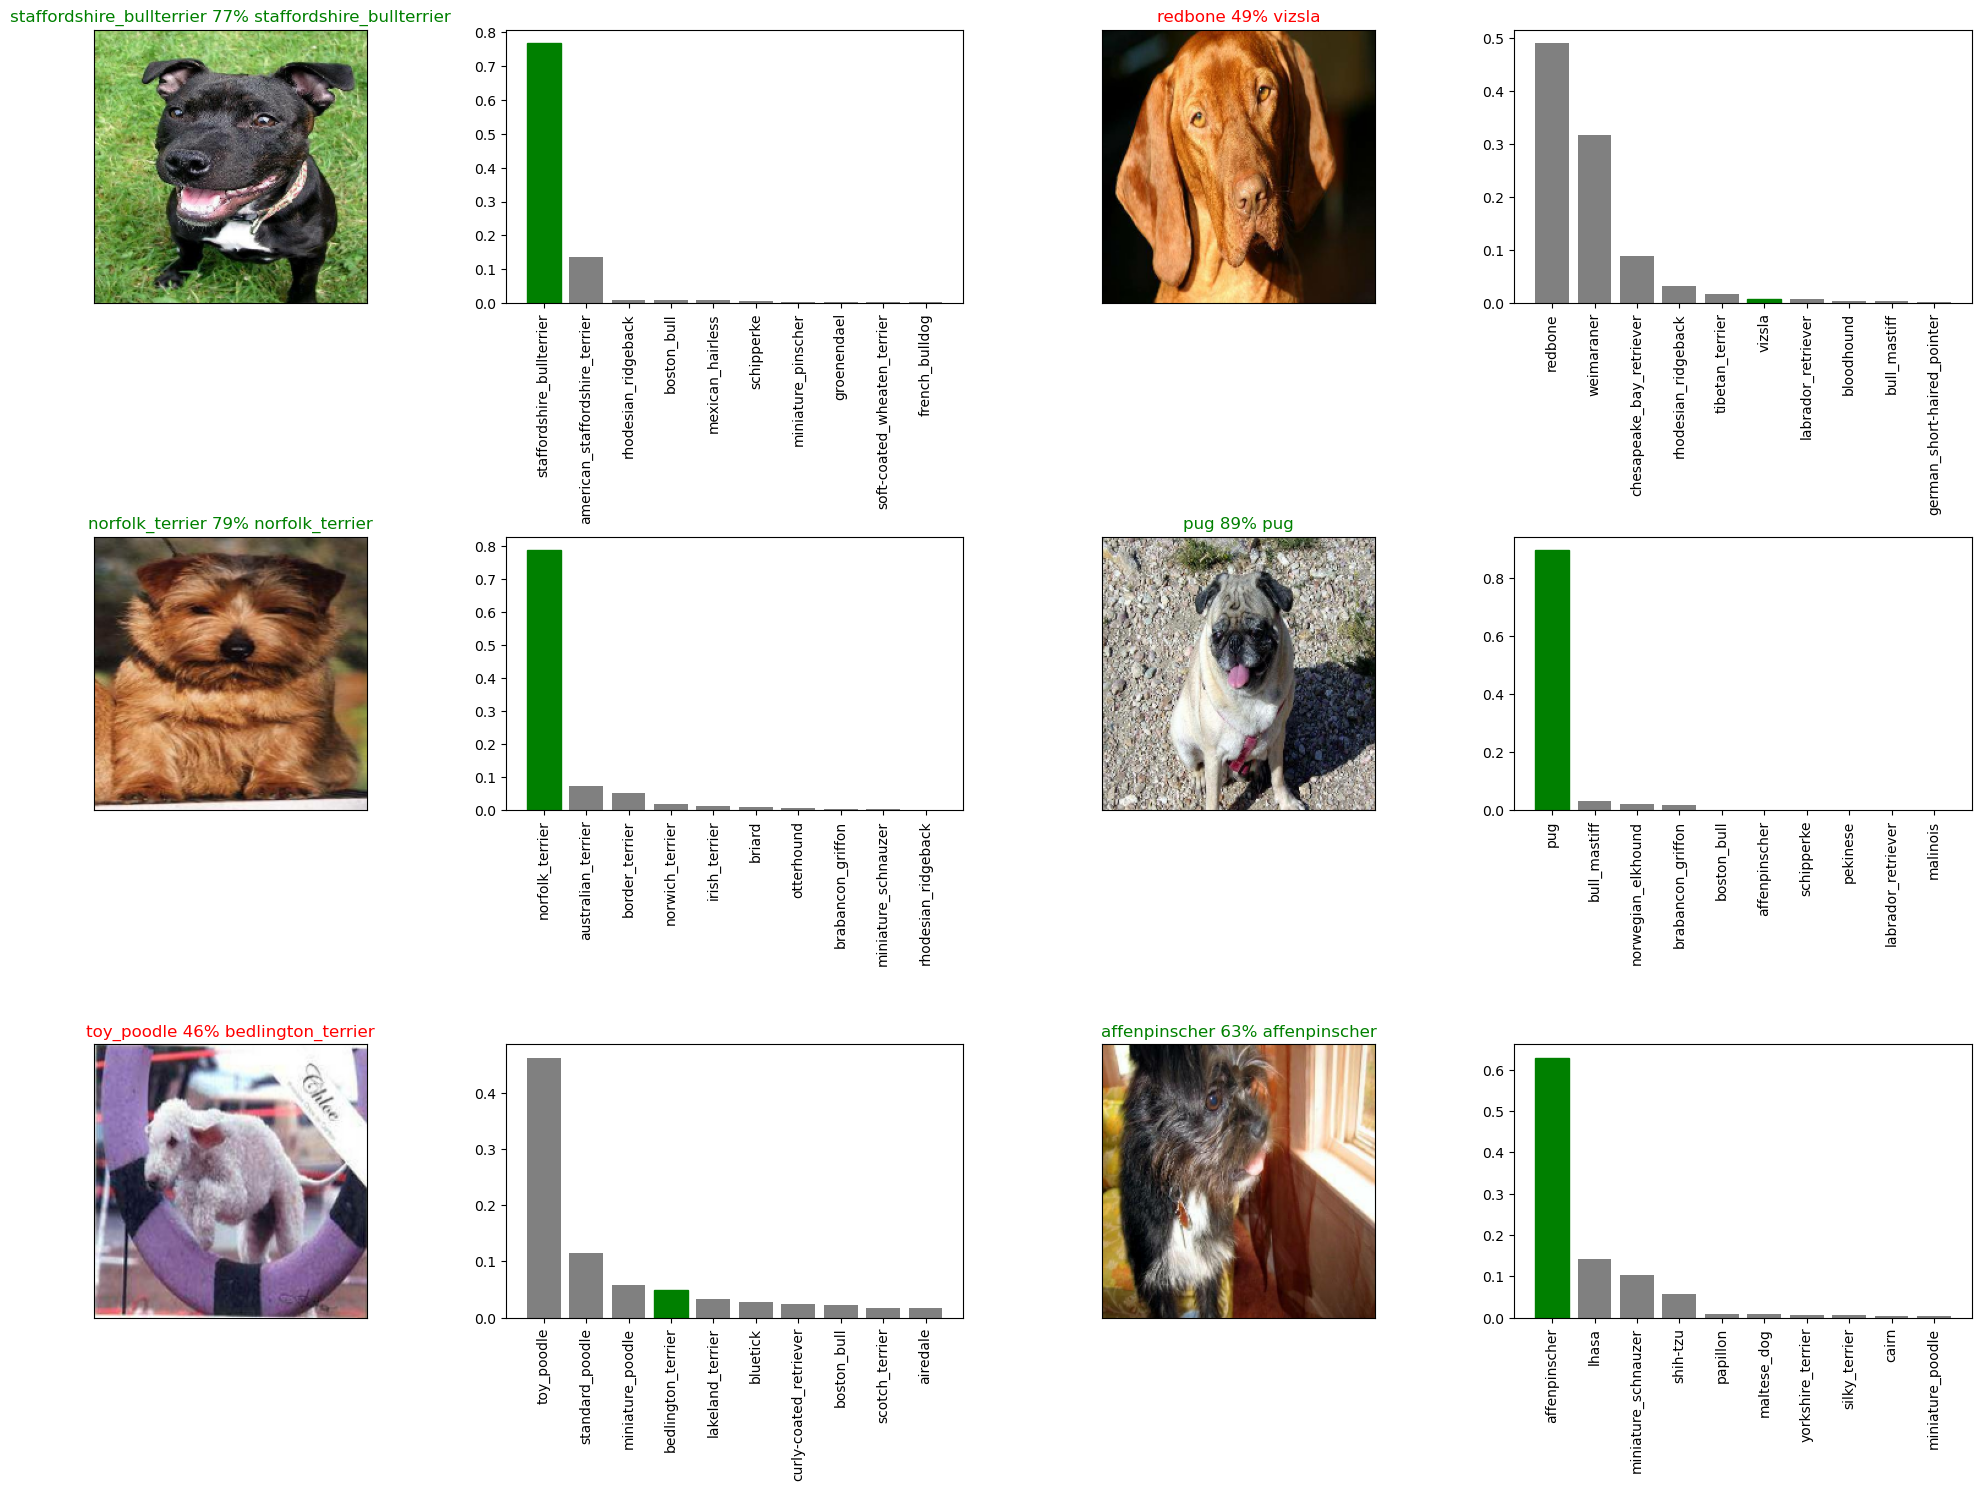

In [73]:
# Let's check out a few predictions and their different values
i_multiplier = 50
num_rows = 3
num_cols =2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilites=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)                  
plt.show()    

**Challenge:** How Would you create a confusion matrix with our models predictions and true labels?

## Saving and reloading a model



In [74]:
# Save a model
def save_model(model, suffix=None):
    """
    Save a given model in a models directory and appends a suffix (string)
    """
    # Create a model directory with current time
    modeldir = os.path.join("models",
                            datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "-" + suffix + ".h5"
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path
    

In [75]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model and returns a trained model.
    """
    print(f"Loading saved model from: {model_path}")
    model = keras.models.load_model(model_path,
                                    custom_objects={"KerasLayer": hub.KerasLayer})
    return model

In [76]:
# Save our model (already saved) kept for saving guidance
# save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [77]:
# reference for loading a model
# loaded_1000_images_model = load_model("models/20250207-18511738921866-1000-images-mobilenetv2-Adam.h5")

In [78]:
# create a confusion matrix using skealrn confusion matrix Display
#from sklearn.metrics import multilabel_confusion_matrix

#dog_confusion_matrix = multilabel_confusion_matrix(y_val_true,
                                                  # y_val_preds,
                                                  #)


## Train a big dig model 🐶 (on the full dataset)

In [79]:
len(X), len(y)

(10222, 10222)

In [80]:
# Crate a data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training batches...


In [81]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [82]:
# Create a model for full dataset
full_model = create_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2


In [83]:
full_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_2 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [84]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when taining on all the data, so we can't monitor validation accracy
full_model_early_stopping = keras.callbacks.EarlyStopping(monitor="accuracy",
                                                          patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minute for the first epoch) because the GPU has to load all of the images into memory.

In [85]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCS.value,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 22s 57ms/step - loss: 1.3421 - accuracy: 0.6707 
Epoch 2/100
320/320 [==============================] - 12s 38ms/step - loss: 0.3994 - accuracy: 0.8846
Epoch 3/100
320/320 [==============================] - 14s 44ms/step - loss: 0.2356 - accuracy: 0.9355
Epoch 4/100
320/320 [==============================] - 14s 45ms/step - loss: 0.1536 - accuracy: 0.9633
Epoch 5/100
320/320 [==============================] - 12s 38ms/step - loss: 0.1071 - accuracy: 0.9791
Epoch 6/100
320/320 [==============================] - 14s 44ms/step - loss: 0.0772 - accuracy: 0.9867
Epoch 7/100
320/320 [==============================] - 12s 38ms/step - loss: 0.0594 - accuracy: 0.9899
Epoch 8/100
320/320 [==============================] - 14s 45ms/step - loss: 0.0470 - accuracy: 0.9941
Epoch 9/100
320/320 [==============================] - 12s 38ms/step - loss: 0.0365 - accuracy: 0.9966
Epoch 10/100
320/320 [==============================] - 14s 45ms/step - 

In [86]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: models/20250209-12441739072672-full-image-set-mobilenetv2-Adam.h5...


/mnt/c/Users/Dspence/Desktop/Data_ML/Dog_Vision_wsl/env/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'models/20250209-12441739072672-full-image-set-mobilenetv2-Adam.h5'

In [87]:
loaded_full_model = load_model("models/20250209-12441739072672-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: models/20250209-12441739072672-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Use the `create_data_batches()` function which can take a list of file names as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test filenames ✅
* Convert the filenames into tes data batches using `create_data_batches` and setting the `test_data`parameter to `True`(since the test data doesn't have labels) ✅
* Make a predictions array by passing the test batches to the `predict()` method called on our model

In [89]:
# Load test image file filenames
test_path = "data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['data/test/000621fb3cbb32d8935728e48679680e.jpg',
 'data/test/00102ee9d8eb90812350685311fe5890.jpg',
 'data/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'data/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'data/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'data/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'data/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'data/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'data/test/002f80396f1e3db687c5932d7978b196.jpg',
 'data/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [91]:
# check the number of images
len(test_filenames)

10357

In [93]:
# Create test data batch
test_data = create_data_batches(test_filenames,
                                test_data=True)

Creating test data batches...


In [94]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about an ~ 1 hour)

In [95]:
# Make predictions on test data batch using the loaded full model 
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 19s 57ms/step


In [96]:
# Save predictions (NumPy array) to a csv file (for access later)
np.savetxt("test_preds_array.csv", test_predictions, delimiter=",")

In [98]:
# Load predictions (NumPy array) from csv file
# test_predicctions = np.loadtxt("file_path + name", delimiter=",")

In [99]:
test_predictions.shape

(10357, 120)

## Preparing test dataset for Kaggle 

Submission requirements link: www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

Looking at the kaggle sample submission, we find that it want our models prediction probabiliy outputs in a DataFrame with an id column and a column for each different dog breed.

To get the data in the format:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed ✅
* Add data to the ID column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit it to Kaggle.

In [100]:
# Create a pandas DataFrame
pred_df = pd.DataFrame(columns=["id"] + list(unique_breeds))

In [101]:
pred_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [105]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:10]

['000621fb3cbb32d8935728e48679680e',
 '00102ee9d8eb90812350685311fe5890',
 '0012a730dfa437f5f3613fb75efcd4ce',
 '001510bc8570bbeee98c8d80c8a95ec1',
 '001a5f3114548acdefa3d4da05474c2e',
 '00225dcd3e4d2410dd53239f95c0352f',
 '002c2a3117c2193b4d26400ce431eebd',
 '002c58d413a521ae8d1a5daeb35fc803',
 '002f80396f1e3db687c5932d7978b196',
 '0036c6bcec6031be9e62a257b1c3c442']

In [106]:
# Add the test ID's to the id column in the preds_df DataFrame
pred_df["id"] = test_ids

In [107]:
pred_df.head()

id affenpinscher afghan_hound  \
0  000621fb3cbb32d8935728e48679680e           NaN          NaN   
1  00102ee9d8eb90812350685311fe5890           NaN          NaN   
2  0012a730dfa437f5f3613fb75efcd4ce           NaN          NaN   
3  001510bc8570bbeee98c8d80c8a95ec1           NaN          NaN   
4  001a5f3114548acdefa3d4da05474c2e           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [108]:
# add the prediction probabilities to each dog breed column
pred_df[list(unique_breeds)] = test_predictions
pred_df.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   9.337516e-12  5.135357e-12   
1  00102ee9d8eb90812350685311fe5890   5.039042e-07  5.247915e-07   
2  0012a730dfa437f5f3613fb75efcd4ce   1.047625e-11  1.099119e-07   
3  001510bc8570bbeee98c8d80c8a95ec1   2.208918e-06  2.046678e-07   
4  001a5f3114548acdefa3d4da05474c2e   3.517000e-05  6.700006e-06   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.714588e-15  1.928698e-14                    2.429840e-13   
1         9.182672e-09  2.374757e-10                    1.975665e-07   
2         2.306481e-09  1.643794e-11                    1.046271e-11   
3         4.296099e-07  2.112622e-07                    4.803886e-06   
4         6.508302e-10  1.827607e-10                    1.204143e-09   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  4.056921e-11        3.332462e-16  1.242944e-12  1.638786e-13  ...   
1  1.982036e-09        3.050661e-07  2.364569e-07  3.079191e-09  ...   
2  8.274439e-10        1.006986e-12  3.242130e-13  9.825029e-11  ...   
3  2.328463e-07        1.328572e-11  4.962517e-10  6.167962e-09  ...   
4  1.367735e-12        7.538262e-11  7.069656e-10  1.366861e-09  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  7.884689e-13  7.795828e-14  1.829057e-13  3.489915e-15  5.703594e-14   
1  5.400944e-09  1.283289e-07  1.272152e-09  3.452586e-06  1.248028e-08   
2  6.573357e-14  5.075492e-12  5.192692e-09  4.322510e-08  5.000256e-08   
3  1.125100e-07  2.561915e-11  1.774361e-06  6.970070e-10  5.402664e-08   
4  5.101020e-08  1.494998e-11  3.616449e-11  1.161983e-11  1.832567e-10   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            1.273308e-12                 5.508685e-13  1.463155e-13   
1            1.988141e-08                 1.976137e-04  3.575886e-12   
2            7.804912e-09                 4.045605e-14  7.031694e-08   
3            2.916707e-10                 6.649391e-17  5.875198e-03   
4            1.914180e-10                 2.376764e-12  2.432891e-08   

   wire-haired_fox_terrier  yorkshire_terrier  
0             5.473262e-10       6.343452e-11  
1             9.876560e-08       7.193519e-11  
2             6.900280e-12       9.157108e-12  
3             1.663803e-12       2.489274e-09  
4             2.392919e-10       3.768529e-09  

[5 rows x 121 columns]

In [109]:
# Export the predictions DataFrame to a CSV file to submit to Kaggle
pred_df.to_csv("full_model_predictions_submission_1_mobilenetV2.csv",
               index=False)

## Making predictions on custom images

To make predictions on custom images:
* Get the file names
* Turn the filepaths into databatches using `creat_data_batches()`. And since our custom images won't have labels, we set the `test_` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted label to the custom images.

In [117]:
custom_path = "original_images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [119]:
custom_image_paths

['original_images/cf9bb7e02c06f97e44beab80589af52b.jpg',
 'original_images/mel_Q8Z5655-scaled.jpg',
 'original_images/Oakleystare.jpg',
 'original_images/pngtree-corgi-on-beach-running-on-the-sand-image_2581657.jpg']

In [120]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, 
                                  test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [121]:
# Make prediction on custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 846ms/step


In [123]:
custom_preds[:2]

array([[1.4538209e-11, 4.7766091e-10, 1.4781800e-08, 1.1822694e-07,
        9.3774672e-04, 8.6571198e-08, 1.8299195e-09, 1.3670708e-10,
        2.2696963e-07, 4.7680729e-07, 1.1637336e-05, 1.8134171e-11,
        6.3245821e-08, 3.5239166e-11, 9.2324592e-10, 2.6172171e-07,
        4.9365352e-09, 1.3288404e-09, 6.6350930e-10, 2.4566874e-10,
        1.7258230e-07, 9.0430115e-07, 1.0397573e-09, 5.8215900e-08,
        3.7153487e-09, 3.8335003e-08, 2.0202147e-10, 3.9280779e-12,
        1.8045682e-06, 1.1055262e-10, 2.7421307e-12, 2.1448885e-05,
        8.9522218e-12, 1.1558363e-09, 2.2196238e-07, 3.9419113e-08,
        4.3017261e-12, 7.2188849e-10, 7.5286785e-06, 8.5520687e-06,
        1.1813093e-05, 1.8258632e-07, 1.7416525e-11, 8.7119272e-09,
        2.8995505e-08, 4.1621044e-09, 2.0080309e-12, 7.6296485e-05,
        8.8732981e-05, 1.6965998e-10, 6.6526791e-11, 9.8187101e-01,
        5.9243188e-08, 9.2679238e-06, 5.2931570e-10, 5.7493403e-06,
        7.0369127e-12, 1.6217294e-07, 4.1369037e

In [124]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['great_dane', 'staffordshire_bullterrier', 'silky_terrier', 'pembroke']

In [125]:
# Get custom images (unbatch_data function won't since there are no labels)
custom_images = []

# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

2025-02-09 14:32:57.182785: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


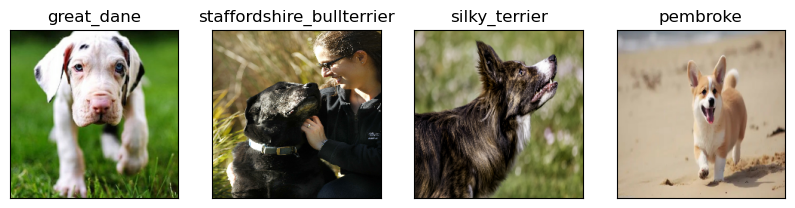

In [128]:
# Check custom image predictions

plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)